In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix

# Utilities

In [3]:
def prepData(locStr):
    data = pd.read_table(locStr, header=None)
    data.columns = ['Sentence','Sentiment']
    data['Sentiment'] = (data['Sentiment'] == 1)
    
    return data

In [4]:
def addFeatures(data, keywords):
    data2 = data.copy()
    for key in keywords:
        data2[str(key)] = data2.Sentence.str.contains(str(key), case=False)
    
    return data2

In [5]:
def trainNB(trainData, targetData):
    bnb = BernoulliNB()
    # Fit our model to the data.
    bnb.fit(trainData, targetData)
    
    return bnb

In [6]:
def evaluateFit(bnb, testData, targetData, name):
    y_pred = bnb.predict(testData)
    accuracy = 1/targetData.shape[0] * (targetData == y_pred).sum()
    confMatrix = 1/targetData.shape[0]*confusion_matrix(targetData, y_pred)
    stats ={'name': name, 'acc': accuracy, 'cm': confMatrix}
    
    return stats

In [7]:
def uncondFit(data, name):
    accuracy = (data['Sentiment']==True).sum()/data.shape[0]
    return {'name':name, 'acc': accuracy, 'cm':None}

In [8]:
def compareStats(allStats):
    for st in allStats:
        print('Name: {}'.format(st['name']))
        print('Accuracy: {}'.format(st['acc']))
        print(st['cm'])
        print('-------------')

# Get the data

In [9]:
amazon = prepData('amazon_cells_labelled.txt')

In [10]:
imdb = prepData('imdb_labelled.txt')

In [11]:
yelp = prepData('yelp_labelled.txt')

# Naive Bayes - U2_L2_P7

In [12]:
positiveKeywords = ['good', 'great','excellent', 'big','large', 'positive']
negativeKeywords = ['waste', 'unsatisfactory', 'disappoint','hype','junk','bad','poor']

In [13]:
allKeywords = positiveKeywords + negativeKeywords

In [14]:
amazon2 = addFeatures(amazon, allKeywords)

In [15]:
# identify train and target
amazonTrain = amazon2[allKeywords].copy()
amazonTarget = amazon2['Sentiment'].copy()

In [16]:
# fit model
amazonNB = trainNB(amazonTrain, amazonTarget)

In [17]:
# evaluate fit
amazonStats = evaluateFit(amazonNB, amazonTrain, amazonTarget, 'amazon_NB_Full')
amazonUncond = uncondFit(amazon2, 'amazonUncond')

In [ ]:
# test on imdb and yelp

In [18]:
# imdb
imdb2 = addFeatures(imdb, allKeywords)
imdbTest = imdb2[allKeywords].copy()
imdbTarget = imdb2['Sentiment'].copy()
imdbStats = evaluateFit(amazonNB, imdbTest, imdbTarget,'amazon_NB_imdb')
imdbUncond = uncondFit(imdb2, 'imdbUncond')

In [19]:
# imdb
yelp2 = addFeatures(yelp, allKeywords)
yelpTest = yelp2[allKeywords].copy()
yelpTarget = yelp2['Sentiment'].copy()
yelpStats = evaluateFit(amazonNB, yelpTest, yelpTarget,'amazon_NB_yelp')
yelpUncond = uncondFit(yelp2, 'yelpUncond')

In [20]:
allStats = [amazonStats, amazonUncond, imdbStats, imdbUncond, yelpStats, yelpUncond]

In [21]:
compareStats(allStats)

Name: amazon_NB_Full
Accuracy: 0.656
[[ 0.482  0.018]
 [ 0.326  0.174]]
-------------
Name: amazonUncond
Accuracy: 0.5
None
-------------
Name: amazon_NB_imdb
Accuracy: 0.553475935828877
[[ 0.46791444  0.01604278]
 [ 0.43048128  0.0855615 ]]
-------------
Name: imdbUncond
Accuracy: 0.516042780748663
None
-------------
Name: amazon_NB_yelp
Accuracy: 0.616
[[ 0.478  0.022]
 [ 0.362  0.138]]
-------------
Name: yelpUncond
Accuracy: 0.5
None
-------------


# Observations

1. In general, the amazonNB works better on yelp than on imdb
2. positiveKeywords seem to be more important than negativeKeywords
3. classifier seems to give non-trivial results for amazon and yelp, but rather trivial results for imdb (classifier accuracy close to unconditional accuracy)
4. classifier seems to have trouble classifying negative sentiment comments (maybe because negative requires 'no' + something?)

Questions:
1. how often are the features in practice something more sophisticated than keywords alone (say a fancy combination of keywords/regular expressions, or an ordered set of words?)
2. how many features are appropriate? Rule of thumb?

# Iterate and evaluate - U2_L3_C4

There are a few dimensions:
1. training set (e.g. full amazon set, part of it, or k-fold)
2. combinations of keywords (positive, negative, positive+negative, fancy combinations?)

In [22]:
propVec = [0.5, 0.75, 0.85, 1]
combKeywords = {'pos':positiveKeywords, 'neg':negativeKeywords, 'pos_neg': positiveKeywords+negativeKeywords}

In [23]:
allData = amazon.copy()
dataset = 'amazon'

In [24]:
ensambleStats = []
for prop in propVec:
    for comb in combKeywords.keys():
        n = int(np.floor(prop*allData.shape[0]))
        keywords = combKeywords[comb]
        
        allData2 = addFeatures(allData, keywords)
        
        train = allData2[keywords].iloc[:n,:].copy()
        target = allData2['Sentiment'].iloc[:n].copy()
        
        dataNB = trainNB(train, target)
        
        if n==allData.shape[0]:
            test = train.copy()
            testTarget = target.copy()
        else:
            test = allData2[keywords].iloc[n:,:].copy()
            testTarget = allData2['Sentiment'].iloc[n:].copy()
            
        stats = evaluateFit(dataNB, test, testTarget, str(prop)+'_'+comb)
        ensambleStats.append(stats)

In [25]:
ensambleStats.append(uncondFit(allData, 'uncond'))

In [26]:
accuracy = [ensambleStats[ii]['acc'] for ii in range(0,len(ensambleStats)) ]

In [27]:
falsePositives = [ensambleStats[ii]['cm'][1,0]   for ii in range(0,len(ensambleStats)-1) ]

In [28]:
falseNegatives = [ensambleStats[ii]['cm'][0,1]   for ii in range(0,len(ensambleStats)-1) ]

In [29]:
labels = [ensambleStats[ii]['name'] for ii in range(0,len(ensambleStats)) ]

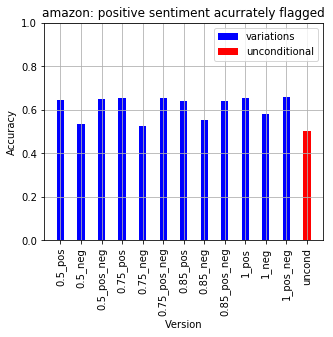

In [30]:
plt.figure(figsize=(5,4))

inds = np.arange(len(accuracy))
width = 0.35
plt.bar(inds, accuracy, width,color='b',label='variations')
plt.bar(inds[-1], accuracy[-1],width, color='r',label='unconditional')
plt.ylim([0,1])
plt.title(dataset + ': positive sentiment acurrately flagged')
plt.xlabel('Version')
plt.ylabel('Accuracy')
plt.xticks(inds,labels, rotation = 90)
plt.legend(loc='best')
plt.grid(b=True)
plt.show()

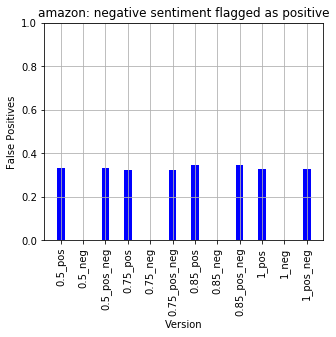

In [32]:
plt.figure(figsize=(5,4))
inds = np.arange(len(falsePositives))
width = 0.35
plt.bar(inds, falsePositives, width,color='b',label='variations')
plt.ylim([0,1])
plt.title(dataset + ': negative sentiment flagged as positive')
plt.xlabel('Version')
plt.ylabel('False Positives')
plt.xticks(inds,labels[:-1], rotation = 90)
plt.grid(b=True)
plt.show()

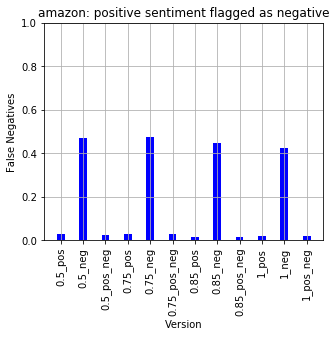

In [33]:
plt.figure(figsize=(5,4))
inds = np.arange(len(falseNegatives))
width = 0.35
plt.bar(inds, falseNegatives, width,color='b',label='variations')
plt.ylim([0,1])
plt.title(dataset + ': positive sentiment flagged as negative')
plt.xlabel('Version')
plt.ylabel('False Negatives')
plt.xticks(inds,labels, rotation = 90)
plt.grid(b=True)
plt.show()